# Analysis of Calgary Business License Data

Dataset provided by: The City of Calgary

In [183]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns
import geopandas as gpd
sns.set(style='white',context='notebook',palette='viridis')
%matplotlib inline

In [5]:
# Import data.
df = pd.read_csv('dat/Calgary_Business_Licences.csv')
df.head()

,TRADENAME,ADDRESS,LICENCETYPES,COMDISTNM,JOBSTATUSDESC,JOBCREATED,longitude,latitude,location,Count
0,MORE CONVENIENCE STORE,11201 30 ST SW,RETAIL DEALER - PREMISES,CEDARBRAE,RENEWAL LICENSED,2009/06/11,-114.130062,50.953449,"(50.9534492575157, -114.130062103058)",1
1,CUBEX,9304 HORTON RD SW,WHOLESALER,HAYSBORO,RENEWAL LICENSED,2014/01/07,-114.075268,50.971295,"(50.9712947174267, -114.075267980215)",1
2,RESTAURANT AT LOUGHEED HOUSE (THE),707 13 AV SW,ALCOHOL BEVERAGE SALES (RESTAURANT),BELTLINE,RENEWAL LICENSED,2009/10/16,-114.077150,51.040573,"(51.0405732559672, -114.077149598877)",1
3,WESTECK WINDOWS AND DOORS,#4 2015 32 AV NE,RETAIL DEALER - PREMISES,SOUTH AIRWAYS,RENEWAL LICENSED,2015/12/07,-114.010275,51.080509,"(51.0805090794563, -114.010274803475)",1
4,ARBOUR LAKE LIQUOR,37 CROWFOOT RI NW,LIQUOR STORE,ARBOUR LAKE,RENEWAL LICENSED,2014/12/10,-114.211064,51.125870,"(51.1258701250349, -114.211064199092)",1


In [7]:
# Describe the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30660 entries, 0 to 30659
Data columns (total 10 columns):
TRADENAME        30660 non-null object
ADDRESS          30660 non-null object
LICENCETYPES     30660 non-null object
COMDISTNM        30660 non-null object
JOBSTATUSDESC    30660 non-null object
JOBCREATED       30660 non-null object
longitude        30660 non-null float64
latitude         30660 non-null float64
location         30660 non-null object
Count            30660 non-null int64
dtypes: float64(2), int64(1), object(7)
memory usage: 2.3+ MB


**Yearly Timeline of All License Transactions**

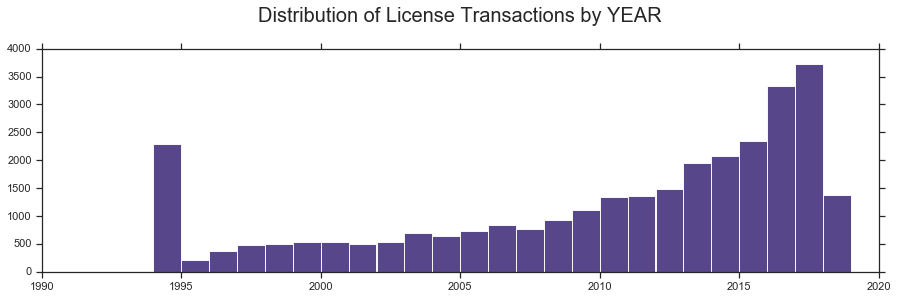

In [279]:
fig,ax=plt.subplots(1,figsize=[15,4])
ax.set_title('Distribution of License Transactions by YEAR\n',fontsize=20)
years = [int(date.split('/')[0]) for date in df['JOBCREATED']]
sns.distplot(years,kde=False,bins=[1990+i for i in range(30)],ax=ax,hist_kws={'alpha':0.9})

Regarding the above figure, why is there a large spike in transactions in the first year of data recording? This is (probably) not a real feature and related to the actual data-intake process considering. How about the same distribution but with NEW licenses only, since most of the dataset is License Renewals?

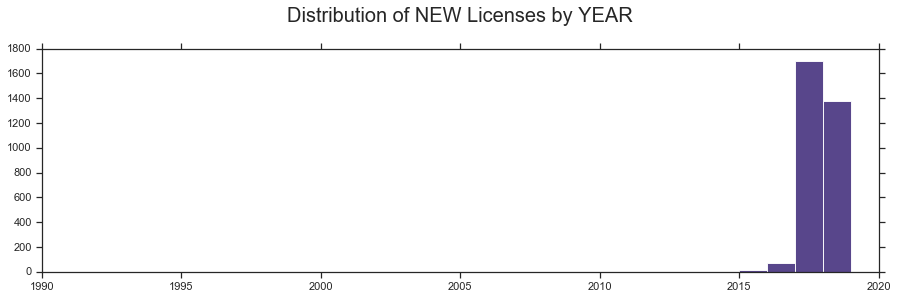

In [293]:
fig,ax=plt.subplots(1,figsize=[15,4])
ax.set_title('Distribution of NEW Licenses by YEAR\n',fontsize=20)
new = df[df['JOBSTATUSDESC']=='LICENSED']
years = [int(date.split('/')[0]) for date in new['JOBCREATED']]
sns.distplot(years,kde=False,bins=[1990+i for i in range(30)],ax=ax,hist_kws={'alpha':0.9})

Regarding the above, it appears there are no new licenses issued before roughly 2015. Is this really true?

### Categorical Column Explorations

JOBSTATUSDESC: Description of the License Transaction

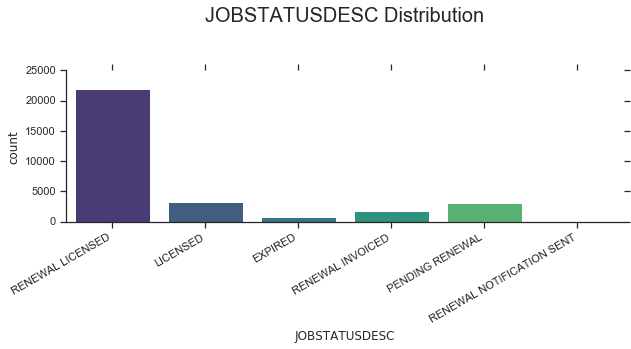

In [290]:
var = 'JOBSTATUSDESC'
fig,ax=plt.subplots(figsize=[10,3])
sns.countplot(df[var],ax=ax)
ax.set_title('{} Distribution\n\n'.format(var),fontsize=20)
sns.despine(ax=ax)
plt.gcf().autofmt_xdate()

LICENCETYPES: Type of Business License in Transaction  
Let's only plot the TOP 15 for space sake. Most are a single class anyhow!

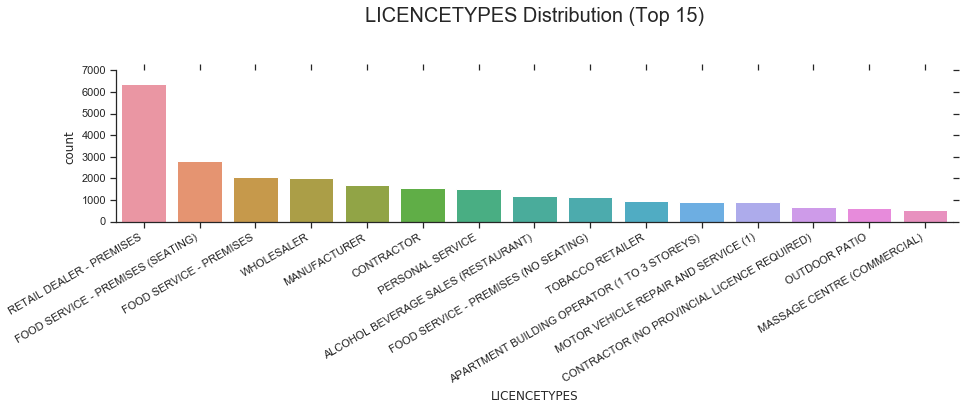

In [280]:
var = 'LICENCETYPES'
fig,ax=plt.subplots(figsize=[15,3])
sns.countplot(x=df[var],ax=ax,order=df[var].value_counts().iloc[:15].index)
ax.set_title('{} Distribution (Top 15)\n\n'.format(var),fontsize=20)
sns.despine(ax=ax)
plt.gcf().autofmt_xdate()

TRADENAME: The company name making the transaction

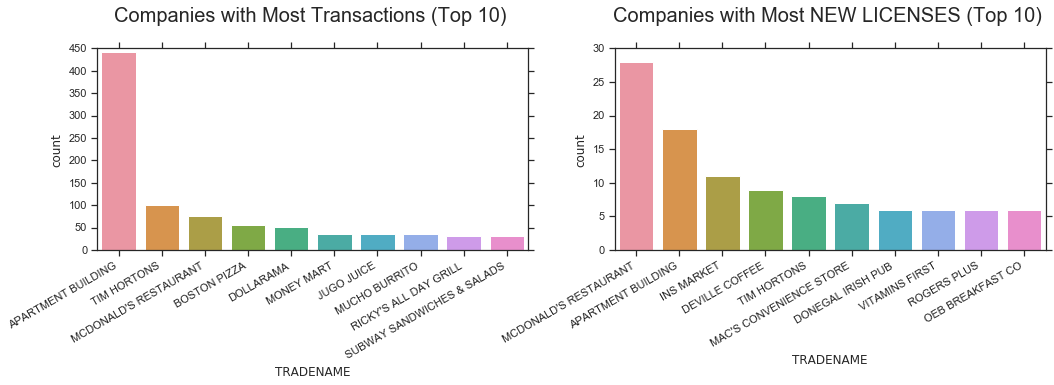

In [289]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=[17,4])
# Plot for all transactions.
sns.countplot(x=df['TRADENAME'],ax=axes[0],order=df['TRADENAME'].value_counts()[:10].index)
axes[0].set_title('Companies with Most Transactions (Top 10) \n'.format(var),fontsize=20)
# Plot only for NEW transactions.
sns.countplot(x=df[df['JOBSTATUSDESC']=='LICENSED']['TRADENAME'],ax=axes[1],order=df[df['JOBSTATUSDESC']=='LICENSED']['TRADENAME'].value_counts()[:10].index)
axes[1].set_title('Companies with Most NEW LICENSES (Top 10) \n'.format(var),fontsize=20)
#sns.despine(ax=ax)
plt.gcf().autofmt_xdate()

**Top 10 Businesses with Most New Licenses Opened**

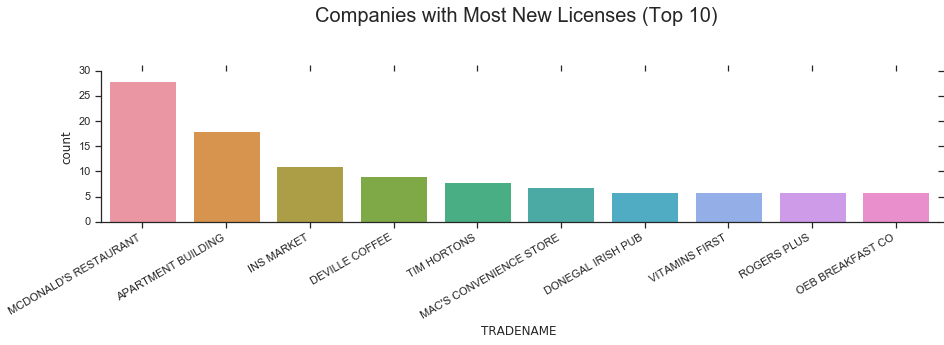

In [260]:
fig,ax = plt.subplots(1,figsize=[15,3])
# Observations that opened new license.
new = df[df['JOBSTATUSDESC']=='LICENSED']
# Plot their company names.
sns.countplot(x=new['TRADENAME'],ax=ax,order=new['TRADENAME'].value_counts()[:10].index)
ax.set_title('Companies with Most New Licenses (Top 10) \n\n'.format(var),fontsize=20)
sns.despine(ax=ax)
plt.gcf().autofmt_xdate()

Wow! McDonalds sure has licensed a lot of franchises in Calgary. Regarding the above list of the top ten it might be interesting to look at the spatial distributions of McDonalds, or Tim Hortons - they are huge competitors in the 'breakfast coffee' market and their distributions are likely correlated. 

**Analysis Idea: McDonalds and Tim Hortons openings since 2011**

"McDonald's launched the McCafe coffee brand in Canada in 2011, and since, the company has doubled its market share in coffee and tripled its coffee sales. Around 78% of the coffee consumption in Canada is through at-home format, and the company wants to capture this market through its retail coffee products." - https://www.forbes.com/sites/greatspeculations/2014/10/03/mcdonalds-mccafe-to-face-stiff-competition-in-canada/#26c4ec4b382f). 

McDonalds started serving McCafe in Canada (2011) and is now known to be outcompeting Tim Hortons at the 'breakfast coffee' game. Is there any license-related behaviour in our data that is related to this scenario? Did McDonalds open more franchises, renew more licenses, or did Tim Hortons open more stores to compete? What's the spatial pattern to choosing where McDonald franchises will be opened, and can we predict a new opening given historical openings in the city?

Just some ideas!

## Geographical Distribution of License Transactions

We'd like to show the distribution of the license transactions in the data using a map of Calgary. In the Calgary_Community_Boundaries.ipynb notebook of the project we import and shortly explore the shapefile of Calgary. Here we import it, compute the number of licenses in each of the communities/Polygons in the map and display.

Number of communities in MAP but NOT in LICENCE data are: 71


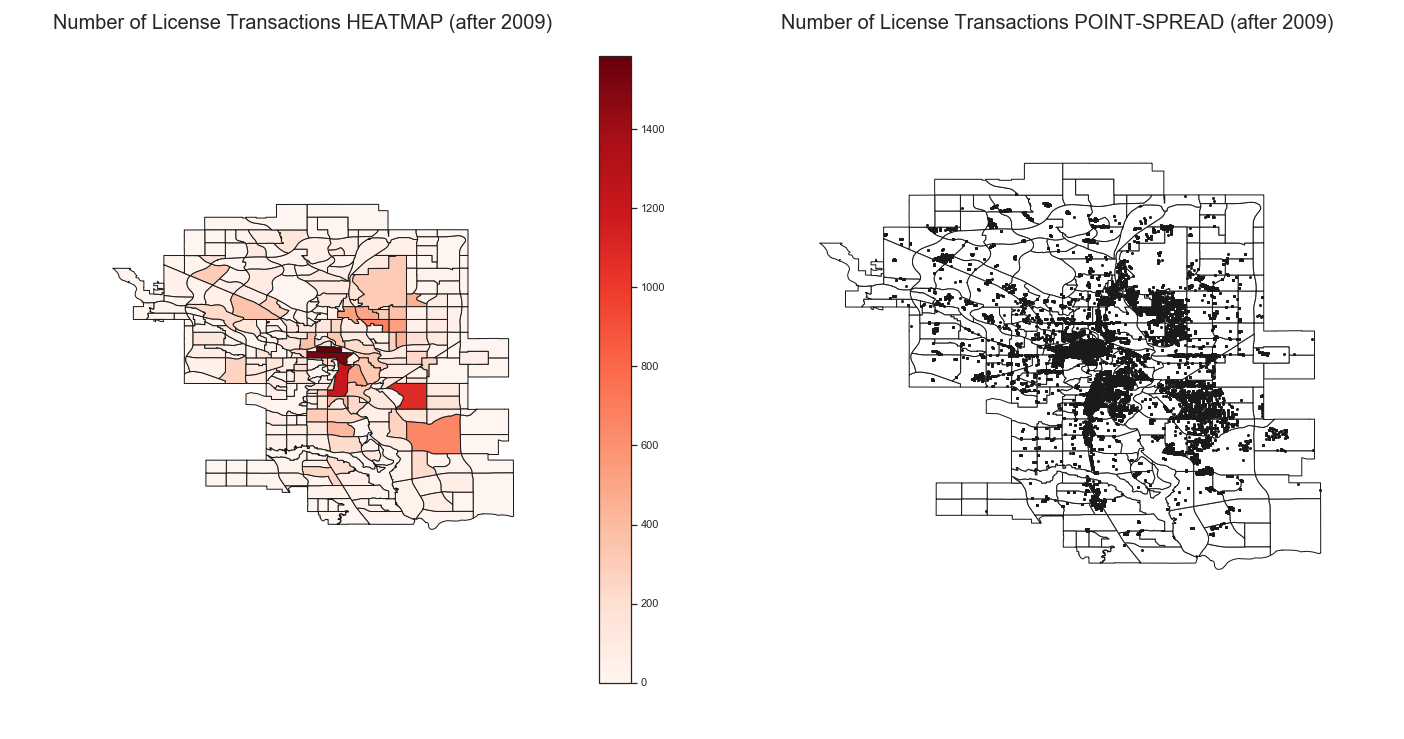

In [222]:
# Import map.
import geopandas as gpd
map_df = gpd.read_file('dat/Calgary_Community_Boundaries/geo_export_98191e70-c41b-4550-8551-d9977b2f1bde.shp')

# The number of times each community name appears in the license data is the number of transactions in each comm.
df['COMDISTNM'].value_counts()
ns = []
# Communities that have no license data (for whatever reason)
not_in_lic = []

for i,line in map_df.iterrows():
    community = line['name']
    # Number of times it appears in license data.
    try:
        n = df['COMDISTNM'].value_counts()[community]
    except KeyError: # when there's a named community not shown in the license data.
        not_in_lic.append(community)
        n = 0
        pass
    ns.append(n)

# Create column.
map_df['N_transactions'] = ns
print('Number of communities in MAP but NOT in LICENCE data are: {}'.format(len(not_in_lic)))

# Figure and axes.
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[20,10],sharex=True)

# Left plot: heatmap of number of transactions.
map_df.plot(ax=axes[0],column='N_transactions',cmap='Reds',edgecolor='0.1',legend=True)
axes[0].set_title('Number of License Transactions HEATMAP (after 2009)\n',fontsize=20)

# Right plot: point distribution of license transactions (plot map, then the points).
map_df.plot(ax=axes[1],color='white',edgecolor='0.1')
plt.scatter(df['longitude'],df['latitude'],s=4,c='k',edgecolor='k')
axes[1].set_title('Number of License Transactions POINT-SPREAD (after 2009)\n',fontsize=20)

# Rescale and turn off axes.
for ax in axes:
    ax.set(ylim=[50.75,51.3])
    ax.axis('off')

## Clean layout.
plt.tight_layout()
plt.subplots_adjust()

# Save fig.
savestring = 'transactions_heatmap.png'
plt.savefig('figs/' + savestring)

## Timeline of Business License Data

The JOBCREATED variable is the date (yyyy/mm/dd) of the datapoint. 

On that date, one of the following transactions occurred:

- RENEWAL LICENSED
- LICENSED
- PENDING RENEWAL
- RENEWAL INVOICED
- EXPIRED
- RENEWAL NOTIFICATION SENT

These are different transactions and should be analyzed accordingly. 

Let's start with a full timeline of licensed businesses (those for the first time), and stratify by COMMDISTNM (community name).

Convert dates to datetime objects.

In [177]:
import datetime
year, month, day = [int(x[:4]) for x in df['JOBCREATED']], [int(x[5:7]) for x in df['JOBCREATED']] ,[int(x[8:10]) for x in df['JOBCREATED']] 
dates = []

for i in range(len(year)):
    dt = pd.datetime(year=year[i],month=month[i],day=day[i])
    dates.append(dt)

# Assign a date column.
df['Date'] = dates

Let's plot the timeline of each individual community. 

In [ ]:
dfByComm = df.groupby('')